In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('HistoricalData_1677625629476-2.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = df['Close'].astype(str)
df['Close'] = df['Close'].str.replace(',', '')
df['Close'] = df['Close'].astype(float)

In [ ]:
df.head()

,Date,Close,Open,High,Low
0,2023-02-27,3982.24,3992.36,4018.05,3973.55
1,2023-02-24,3970.04,3973.24,3978.25,3943.08
2,2023-02-23,4012.32,4018.60,4028.30,3969.19
3,2023-02-22,3991.05,4001.83,4017.37,3976.90
4,2023-02-21,3997.34,4052.35,4052.35,3995.19


In [51]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=df['Date'],y=df['Close'], mode='lines'))
fig.show()

In [76]:
daily_returns = df['Close'].pct_change()

In [77]:
daily_returns.shape

(2541,)

In [78]:
n=5
realized_volatility = daily_returns.rolling(window=n).std() * np.sqrt(n)

In [79]:
realized_volatility.describe()

count    2536.000000
mean        0.019198
std         0.016674
min         0.001183
25%         0.009391
50%         0.014815
75%         0.023898
max         0.218600
Name: Close, dtype: float64

In [80]:
dr_train = daily_returns[:200]
dr_test = daily_returns[200:]
v_train = realized_volatility[:200]
v_test = realized_volatility[200:]
print(dr_train.shape, dr_test.shape, v_train.shape, v_test.shape)

(200,) (2341,) (200,) (2341,)


In [81]:
v_test

200     0.037799
201     0.032486
202     0.047409
203     0.032099
204     0.038058
          ...   
2536    0.005813
2537    0.005836
2538    0.007421
2539    0.007367
2540    0.007611
Name: Close, Length: 2341, dtype: float64

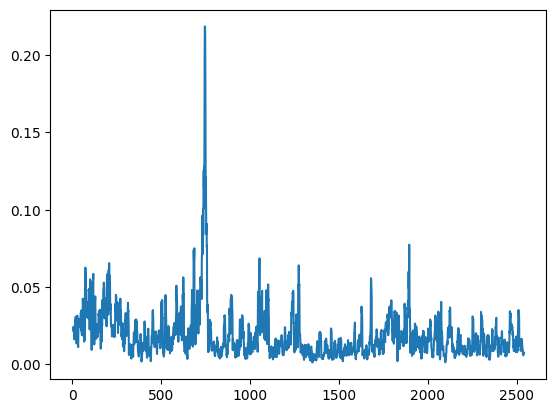

In [82]:
plt.plot(realized_volatility)

In [83]:
from arch import arch_model
from arch.__future__ import reindexing

returns = dr_train.dropna()

In [84]:
returns.describe()

count    199.000000
mean       0.000047
std        0.014634
min       -0.052523
25%       -0.010055
50%        0.001239
75%        0.008668
max        0.045190
Name: Close, dtype: float64

In [85]:
model = arch_model(returns, p=1,q=1, vol='GARCH')
results = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 67813.31000822675
Iteration:      2,   Func. Count:     16,   Neg. LLF: 3697179138961822.0
Iteration:      3,   Func. Count:     30,   Neg. LLF: 1967161641576576.5
Iteration:      4,   Func. Count:     41,   Neg. LLF: 4301.98016796493
Iteration:      5,   Func. Count:     51,   Neg. LLF: 139972562175059.14
Iteration:      6,   Func. Count:     64,   Neg. LLF: 2554870244785.483
Iteration:      7,   Func. Count:     75,   Neg. LLF: 405759426424.0216
Optimization terminated successfully    (Exit mode 0)
            Current function value: -562.0749242315833
            Iterations: 10
            Function evaluations: 85
            Gradient evaluations: 7


/Users/rakeshrathod/Desktop/BrainCTScan/venv/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002131. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




In [ ]:
import arch

daily_returns.shape

(2541,)

In [ ]:
rolling_predictions = []
aic = []
bic = []

lags = 10
lb_test = []

daily_returns = daily_returns.dropna()
print(daily_returns)
test_size = len(daily_returns)-1#len(dr_test)-1

for i in range(test_size):
    np.seterr(divide='ignore', invalid='ignore')
    returns = daily_returns[:-(test_size-i)]
    model = arch_model(returns, p=2, q=2, vol = 'GARCH', rescale=False)
    model_fit = model.fit(disp='off')
    aic.append(model_fit.aic)
    bic.append(model_fit.bic)
    pred = model_fit.forecast(horizon=5)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

1      -0.003064
2       0.010650
3      -0.005301
4       0.001576
5       0.020451
          ...   
2536   -0.001813
2537   -0.001083
2538   -0.009475
2539   -0.004590
2540   -0.002319
Name: Close, Length: 2540, dtype: float64


/Users/rakeshrathod/Desktop/BrainCTScan/venv/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.


/Users/rakeshrathod/Desktop/BrainCTScan/venv/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.


/Users/rakeshrathod/Desktop/BrainCTScan/venv/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.


/Users/rakeshrathod/Desktop/BrainCTScan/venv/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for line

In [ ]:
rolling_predictions = []
aic = []
bic = []

lags = 10
lb_test = []

daily_returns = daily_returns.dropna()
print(daily_returns)
test_size = len(daily_returns)-1#len(dr_test)-1

for p in range(1,3):
    for q in range(1,3):
        for i in range(test_size):
            np.seterr(divide='ignore', invalid='ignore')
            returns = daily_returns[:-(test_size-i)]
            model = arch_model(returns, p=p, q=q, vol = 'GARCH', rescale=False)
            model_fit = model.fit(disp='off')
            
            pred = model_fit.forecast(horizon=5)
            rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    aic.append(model_fit.aic)
    bic.append(model_fit.bic)

1      -0.003064
2       0.010650
3      -0.005301
4       0.001576
5       0.020451
          ...   
2536   -0.001813
2537   -0.001083
2538   -0.009475
2539   -0.004590
2540   -0.002319
Name: Close, Length: 2540, dtype: float64


/Users/rakeshrathod/Desktop/BrainCTScan/venv/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.


/Users/rakeshrathod/Desktop/BrainCTScan/venv/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.


/Users/rakeshrathod/Desktop/BrainCTScan/venv/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.


/Users/rakeshrathod/Desktop/BrainCTScan/venv/lib/python3.9/site-packages/arch/univariate/base.py:753: ConvergenceWarning:

The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See 

KeyboardInterrupt: 

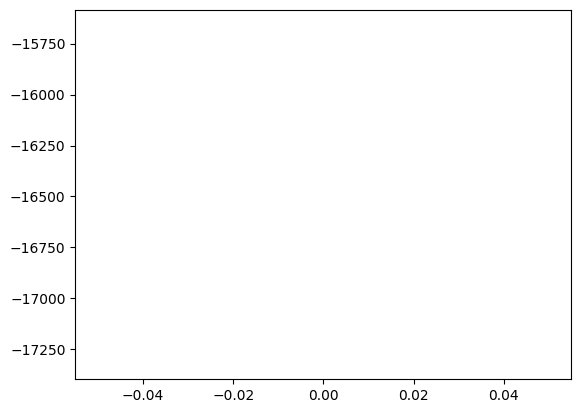

In [126]:
plt.plot(aic)

Text(0.5, 1.0, 'Rolling Prediction')

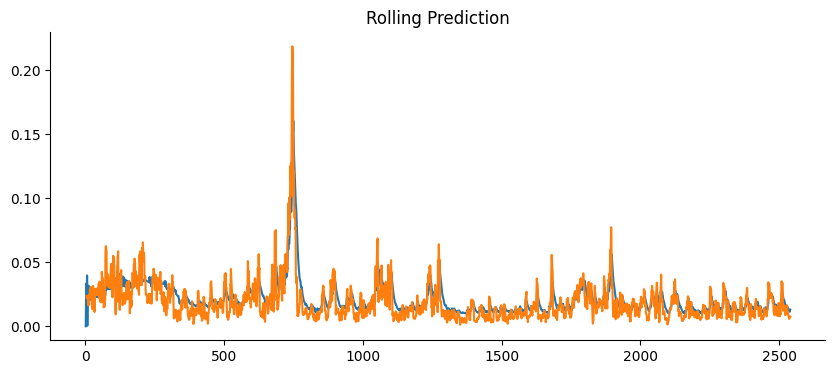

In [118]:
rolling_predictions = pd.Series(rolling_predictions, index=df['Close'].index[-2539:])

fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot((rolling_predictions * 5**0.5))
plt.plot(realized_volatility)
plt.title('Rolling Prediction')

In [122]:
vol_pred = rolling_predictions* 5**0.5
print(vol_pred.shape, realized_volatility.shape)

(2539,) (2541,)


[nan,
 -2.2543708765786263,
 -10.4889112534273,
 -17.497335006152,
 -21.395035239862878,
 -31.032382773389543,
 -36.84110407759131,
 -43.1160798495316,
 -50.40538607841209,
 -53.596404204274776,
 -61.383269814728564,
 -68.04477881871182,
 -74.82120495769246,
 -79.38591856520911,
 -86.7074067665739,
 -93.55856347008604,
 -97.88531086321748,
 -103.76856300900599,
 -108.84660954159885,
 -114.83390512392185,
 -121.89602248674208,
 -127.90012529889003,
 -135.2685175855504,
 -142.66568915697925,
 -148.53420091516082,
 -152.60533857183586,
 -159.27366984047913,
 -164.40335313239558,
 -171.5448256997467,
 -178.61396711590157,
 -185.8931597568169,
 -191.70231930506472,
 -198.71100425365233,
 -206.0595270184342,
 -208.85851211647034,
 -214.71639687016207,
 -221.51924509554655,
 -228.58603519062916,
 -235.79549761050626,
 -240.6504588869193,
 -246.36672167369284,
 -253.4159550367695,
 -260.4671419240538,
 -265.61991130839226,
 -271.16908824043975,
 -278.37787489273074,
 -284.7524005396869,
 -290.

In [91]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()
s = realized_volatility.to_numpy()
s = s.reshape(-1,1)
r = rolling_predictions.to_numpy() * 5**0.5
r = r.reshape(-1,1)
scaled_s = scalar.fit_transform(s)
scaled_r = scalar.fit_transform(r)

Text(0.5, 1.0, 'Rolling Prediction')

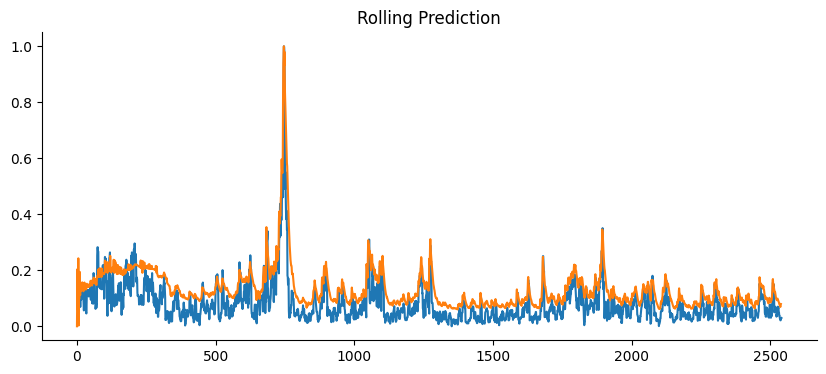

In [99]:
rolling_predictions = pd.Series(rolling_predictions, index=df['Close'].index[-2541:])

fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot((scaled_s))
plt.plot(scaled_r)
plt.title('Rolling Prediction')

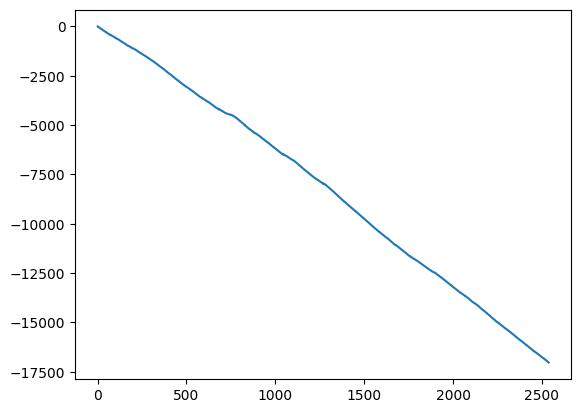

In [100]:
plt.plot(aic)

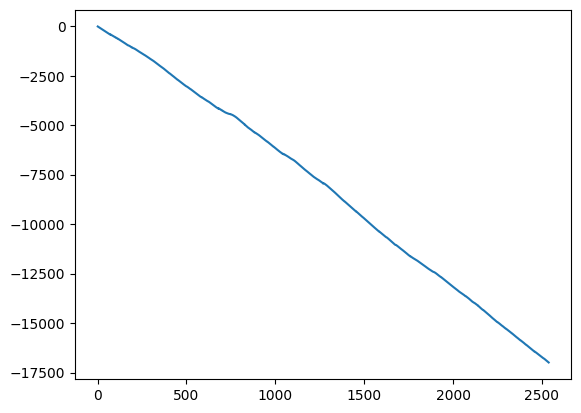

In [101]:
plt.plot(bic)

In [109]:
realized_volatility[5:]

5       0.023807
6       0.022027
7       0.023125
8       0.021567
9       0.022023
          ...   
2536    0.005813
2537    0.005836
2538    0.007421
2539    0.007367
2540    0.007611
Name: Close, Length: 2536, dtype: float64

In [115]:
rolling_predictions[2500:]

2500    0.007045
2501    0.006905
2502    0.006497
2503    0.006223
2504    0.006586
2505    0.006733
2506    0.006721
2507    0.007062
2508    0.008264
2509    0.009476
2510    0.011862
2511    0.012335
2512    0.010899
2513    0.011041
2514    0.010493
2515    0.009845
2516    0.009426
2517    0.008864
2518    0.009044
2519    0.008939
2520    0.008381
2521    0.007986
2522    0.007480
2523    0.007105
2524    0.007009
2525    0.006924
2526    0.006792
2527    0.007176
2528    0.007232
2529    0.006893
2530    0.006801
2531    0.006592
2532    0.006357
2533    0.006135
2534    0.005824
2535    0.005658
2536    0.005504
2537    0.005324
2538    0.005050
2539    0.005588
2540    0.005818
dtype: float64